In [1]:
#!pip install pytorch_memlab

In [2]:
%cd ../

/notebook/mnt/data1/home/a.s.potapov/projects/inpainting_FRRN


In [3]:
import os 
import yaml 
import random
from matplotlib import pyplot as plt

import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.tensorboard import SummaryWriter

In [4]:
from utils.masks import get_padding_values, get_constant_mask, get_padding
from model.layers import PConvBlock, FRRB, Stack, InpaintingGenerator
from data.dataset import Dataset

In [5]:
# ARGS 
config_path = 'experiments/config.yml'
images_path = '../Datasets/Huawei/DATASET_INPAINTING/train_gt/'
masks_path = None#'../DATASET_INPAINTING/images'
checkpoint = None
training = True

In [6]:
code_path = './'
with open(os.path.join(code_path, config_path), 'r') as f:
    pretty_config = f.read()
    config = yaml.load(pretty_config, yaml.Loader)

In [7]:
# cuda visble devices
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

# init device
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True   # cudnn auto-tuner
else:
    device = torch.device("cpu")

In [8]:
initial_mask = get_constant_mask()
inpainting = InpaintingGenerator(config, initial_mask).to(device)

if len(config['gpu']) > 1:
    inpainting = nn.DataParallel(inpainting, config['gpu'])
    
inpainting.train()

DataParallel(
  (module): InpaintingGenerator(
    (frrb): ModuleList(
      (0): FRRB(
        (left): Stack(
          (mod): ModuleList(
            (0): PConvBlock(
              (pconv): PartialConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (act): ReLU()
            )
            (1): PConvBlock(
              (pconv): PartialConv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (norm): InstanceNorm2d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (act): ReLU()
            )
            (2): PConvBlock(
              (pconv): PartialConv2d(96, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (act): ReLU()
            )
            (3): PConvBlock(
        

In [9]:
batch_size = config['training']['batch_size']
# create dataset
dataset = Dataset(config['dataset'], config['path']['train'], masks_path, training)
train_loader = dataset.create_iterator(batch_size)

In [10]:
learning_rate = config['training']["learning_rate"]
betas = (config['training']["beta1"], config['training']["beta2"])
optimizer = torch.optim.Adam(inpainting.parameters(), 
                             lr=learning_rate, betas=betas)

In [11]:
def compute_loss(input, target, loss_mask):
    """ MSE Loss """
    delta = input*loss_mask - target*loss_mask
    delta = torch.abs(delta) # ** 2
    return torch.mean(delta)

In [12]:
from pytorch_memlab import MemReporter

reporter = MemReporter(inpainting)

tensor(0.0038, device='cuda:0', grad_fn=<MeanBackward0>)


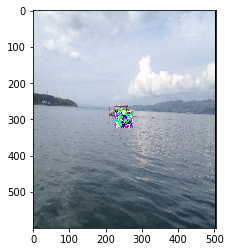

tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)


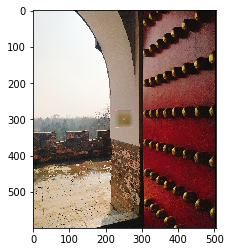

tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)


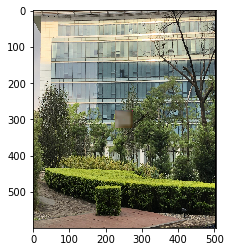

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)


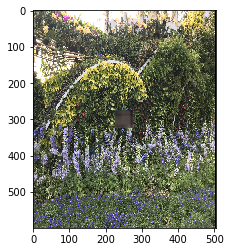

tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)


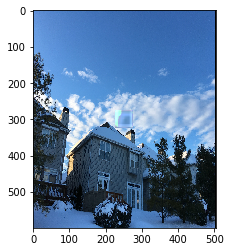

tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)


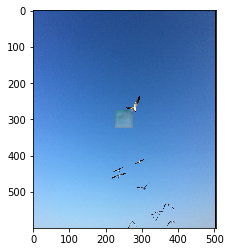

In [ ]:
for i, items in enumerate(train_loader):
    images = items['image'].to(device)
    masks = items['mask'].to(device)
    
    result, output, new_mask = inpainting(images, masks)
    #reporter.report()
    
    loss_mask = (new_mask[0] - masks[0])
    
    loss = compute_loss(result, images, loss_mask)
    loss.backward()
    #reporter.report()
    
    optimizer.step()
    
    
    if i % 100 ==0:
        print(loss)
        plt.imshow((result[0].detach().cpu()).permute(1,2,0))
        plt.show()

# Test

In [ ]:
url = 'https://images.unsplash.com/photo-1500382017468-9049fed747ef?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80'

In [ ]:
test_image = items['image'][:1]
test_image[:,:, 100:150, 100:150] = 0.0
test_image.shape

In [ ]:
test_mask = torch.ones((1,1,600,504))
test_mask[:,:, 100:150, 100:150] = 0.0
test_mask.shape

In [ ]:
result, output, new_mask = inpainting(test_image, test_mask)
plt.imshow(result[0].detach().cpu().permute(1,2,0))